# Hourly Energy Consumption

About Dataset

https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

## Purpose
The goal of this project is to develop a model that forecasts power demand (MW) in the PJM East region on an hourly basis.

Accurate demand forecasting is crucial for power plant operations, energy purchasing, maintenance, and emergency response. From a business perspective, it helps reduce losses due to under/over-forecasting and contributes to efficient resource management.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import kagglehub
import shutil
import os
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Downloading Data

In [16]:
# download data from kaggle
temp_path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

# add to local folder
target_path ="/content/drive/MyDrive/energy_projection/data"

# create folder if not exist
os.makedirs(target_path, exist_ok=True)

# copy files to path
for file_name in os.listdir(temp_path):
    shutil.copy(os.path.join(temp_path, file_name), target_path)

print("Dataset copied to:", target_path)


Dataset copied to: /content/drive/MyDrive/energy_projection/data


In [17]:
data_path = '/content/drive/MyDrive/energy_projection/data/PJME_hourly.csv'
df = pd.read_csv(data_path, parse_dates=['Datetime'], index_col='Datetime')
print(df.shape)
print(df.info())
print(df.head())

(145366, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None
                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0


## Exploratory Data Analysis
- Data covers hourly electricity demand from 2002 to 2018 (about 16 years)
- Main columns: Datetime (timestamp), PJME_MW (demand)
- Strong annual, seasonal, and weekly cycles are observed in the time series
- Noticeable demand peaks in summer and winter; clear weekday/weekend effects

### Summary

In [18]:
# check for null values
print(df.isnull().sum())

# summary
print(df.describe())

PJME_MW    0
dtype: int64
             PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000


### Energy Consumption by Date

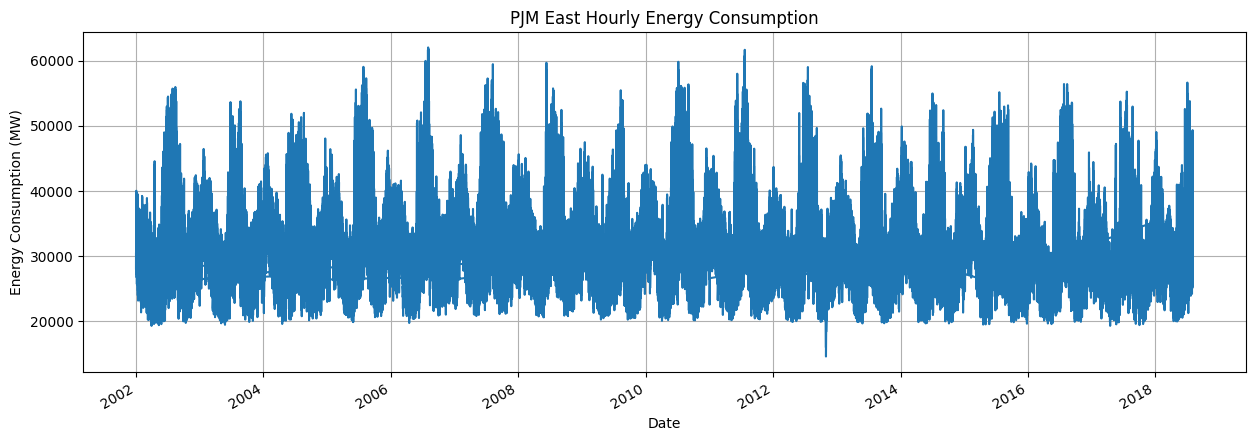

In [19]:
# visualize
df['PJME_MW'].plot(figsize=(15, 5), title='PJM East Hourly Energy Consumption')
plt.xlabel("Date")
plt.ylabel("Energy Consumption (MW)")
plt.grid(True)
plt.show()

#### Looking at last 365 days

<ipython-input-20-3475690828>:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_last_year = df.last("365D")


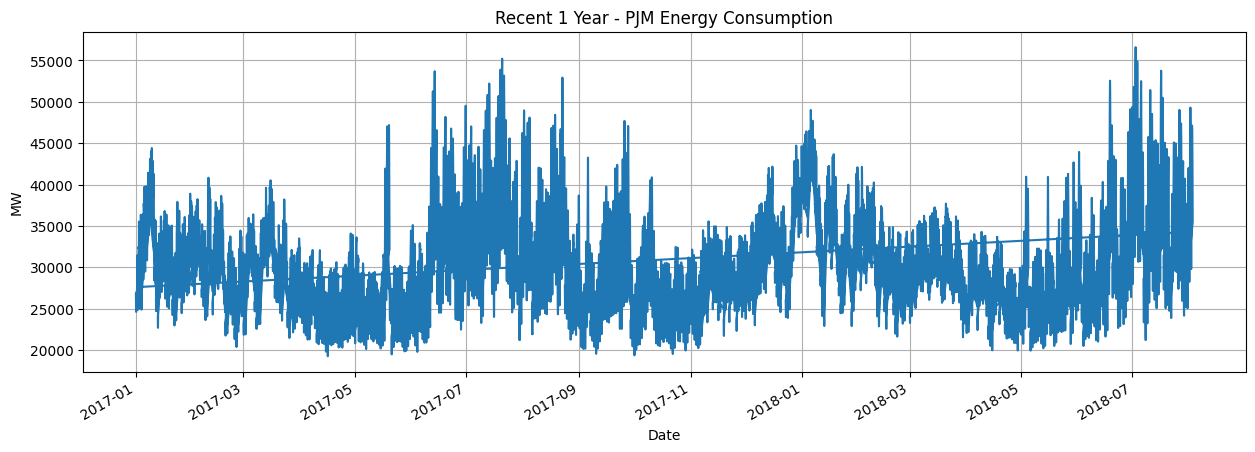

In [20]:
# visualize last 365D

df_last_year = df.last("365D")

df_last_year['PJME_MW'].plot(figsize=(15, 5), title='Recent 1 Year - PJM Energy Consumption')
plt.xlabel("Date")
plt.ylabel("MW")
plt.grid(True)
plt.show()

### Monthly Average Consumption

Text(0, 0.5, 'Average MW')

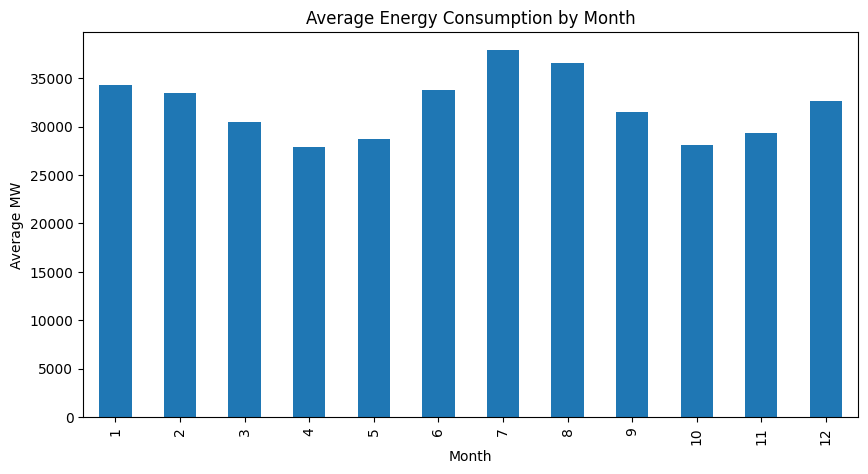

In [21]:
# visualize monthly
monthly_avg = df['PJME_MW'].groupby(df.index.month).mean()

plt.figure(figsize=(10,5))
monthly_avg.plot(kind='bar')
plt.title('Average Energy Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average MW')

### Energy Consumption by Day of Week

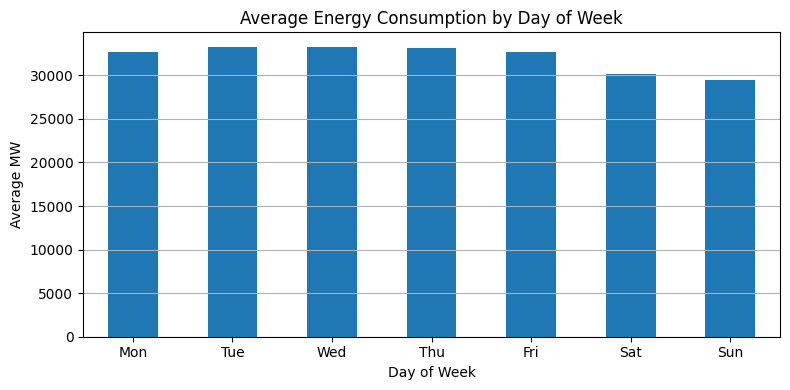

In [22]:
# by day of week
weekday_avg = df['PJME_MW'].groupby(df.index.dayofweek).mean()

plt.figure(figsize=(8, 4))
weekday_avg.plot(kind='bar')
plt.title('Average Energy Consumption by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average MW')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Hourly Average Consumption

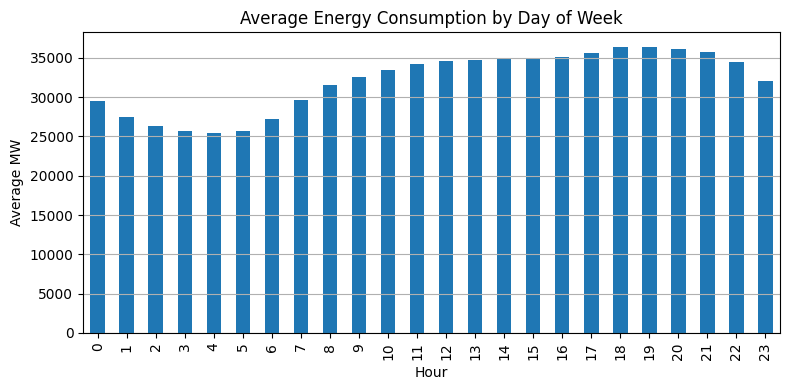

In [23]:
# by hour
# by day of week
hourly_avg = df['PJME_MW'].groupby(df.index.hour).mean()

plt.figure(figsize=(8, 4))
hourly_avg.plot(kind='bar')
plt.title('Average Energy Consumption by Day of Week')
plt.xlabel('Hour')
plt.ylabel('Average MW')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Seasonal Decompose

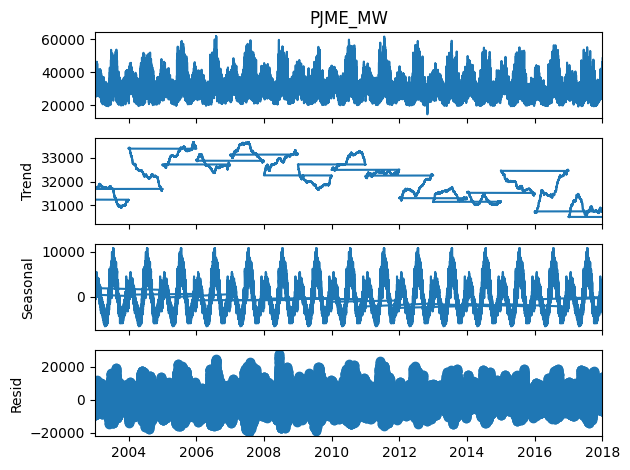

In [24]:
#
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['PJME_MW'], model='additive', period=24*365)
result.plot()
plt.tight_layout()
plt.show()

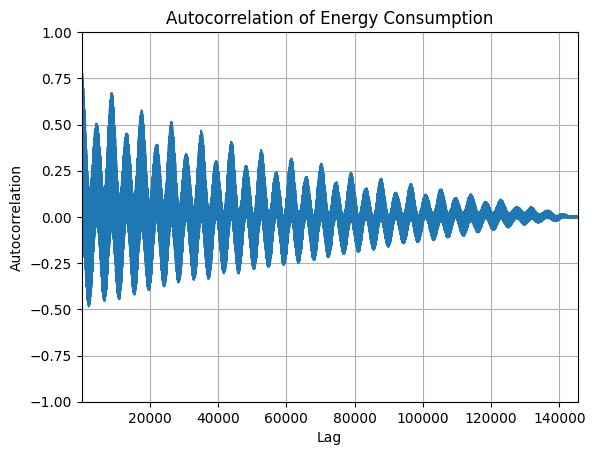

In [25]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['PJME_MW'])
plt.title("Autocorrelation of Energy Consumption")
plt.show()

## Feature Engineering

For this project, we incorporated the following variables to enhance predictive performance:

- **hour**: captures intra-day demand variation  
- **dayofweek**: accounts for weekday/weekend and day-specific demand patterns  
- **month**: captures seasonal and annual effects  
- **is_weekend**: distinguishes between weekdays and weekends  
- **lag_1**: previous hour’s demand, captures short-term temporal dependence  
- **lag_24**: demand from the same hour on the previous day, reflects daily seasonality  
- **lag_168**: demand from the same hour one week ago, captures weekly repeating patterns  

These engineered features enable the model to learn from both temporal cycles and direct historical dependencies, allowing for more accurate and robust demand forecasting in a real-world operational setting.


In [76]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

df['lag_1'] = df['PJME_MW'].shift(1)
df['lag_24'] = df['PJME_MW'].shift(24)
df['lag_168'] = df['PJME_MW'].shift(168)

df = df.dropna() # b/c 1st row has a n/a value

## Train/Test Split

In [77]:
# separate train/test
test_size = 24 * 365
df = df.sort_index()
df_train = df[:-test_size]
df_test  = df[-test_size:]
print(df_train.shape)
print(df_test.shape)

(136438, 9)
(8760, 9)


## Modeling

### Prophet
Prophet is a time series forecasting model that automatically captures trend and seasonality.  
By adding external regressors (e.g., hour, day of week), we enhance its ability to reflect business cycles and structural effects.


In [78]:
# format data for prophet
df = df.sort_index()
df_prophet = df.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})
train_prophet = df_prophet[:-test_size]
test_prophet  = df_prophet[-test_size:]


In [79]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.add_regressor('hour')
model.add_regressor('dayofweek')
model.add_regressor('month')
model.add_regressor('is_weekend')
model.add_regressor('lag_1')
model.add_regressor('lag_24')
model.add_regressor('lag_168')
model.fit(train_prophet)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpo6nsl0iv/spo580pt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo6nsl0iv/qi20qauf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50371', 'data', 'file=/tmp/tmpo6nsl0iv/spo580pt.json', 'init=/tmp/tmpo6nsl0iv/qi20qauf.json', 'output', 'file=/tmp/tmpo6nsl0iv/prophet_modelem67_wns/prophet_model-20250611063856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:38:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:39:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [80]:
future = test_prophet[['ds', 'hour', 'dayofweek', 'month', 'is_weekend', 'lag_1', 'lag_24', 'lag_168']]
forecast = model.predict(future)
test_prophet['yhat'] = forecast['yhat'].values


<ipython-input-80-376409335>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prophet['yhat'] = forecast['yhat'].values


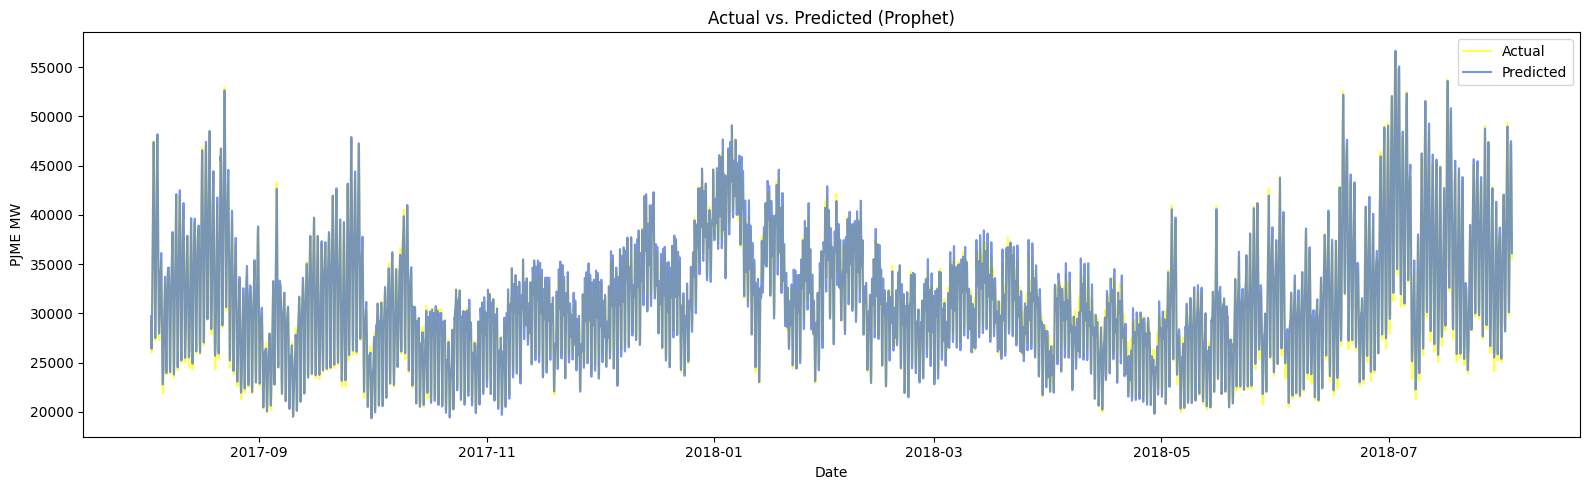

In [82]:
plt.figure(figsize=(16, 5))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual', color='yellow', alpha=0.7)
plt.plot(test_prophet['ds'], test_prophet['yhat'], label='Predicted', color='royalblue', alpha=0.7)

plt.legend()
plt.title('Actual vs. Predicted (Prophet)')
plt.xlabel('Date')
plt.ylabel('PJME MW')
plt.tight_layout()
plt.show()

### XGBoost
XGBoost is a powerful tree-based regression algorithm.  
Here, it uses engineered time features as predictors to model electricity demand, learning from both temporal and structural relationships in the data.

In [83]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Feature 생성
feature_cols = [
    'hour', 'dayofweek', 'month', 'is_weekend',
    'lag_1', 'lag_24', 'lag_168'
]

X_train = df_train[feature_cols]
y_train = df_train['PJME_MW']
X_test  = df_test[feature_cols]
y_test  = df_test['PJME_MW']

model_xgb = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)


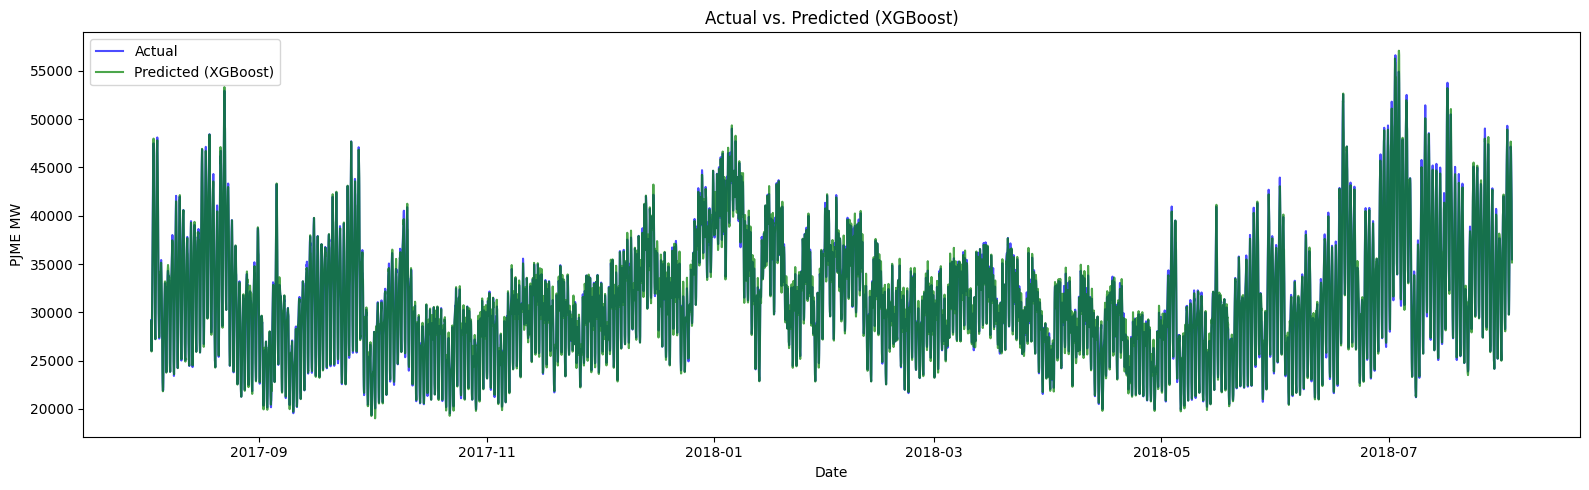

In [86]:
plt.figure(figsize=(16, 5))
plt.plot(df_test.index, y_test, label='Actual', color='blue', alpha=0.7)
plt.plot(df_test.index, y_pred_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.legend()
plt.title('Actual vs. Predicted (XGBoost)')
plt.xlabel('Date')
plt.ylabel('PJME MW')
plt.tight_layout()
plt.show()

## Performance Evaluation
Model performance is evaluated using MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error) on the test set.  

In [87]:
# Prophet
mae_prophet = mean_absolute_error(test_prophet['y'], test_prophet['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], test_prophet['yhat']))

# XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f'Prophet MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}')
print(f'XGBoost MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}')


Prophet MAE: 608.68, RMSE: 792.11
XGBoost MAE: 348.52, RMSE: 462.83


In [88]:
y_pred_naive = df_test['lag_1']
mae_naive = mean_absolute_error(y_test, y_pred_naive)
print('Naive lag_1 MAE:', mae_naive)

Naive lag_1 MAE: 1036.0753424657535


## Conclusion
**Model performance on the test set:**

- Prophet: MAE = 609 MW, RMSE = 792 MW
- XGBoost: MAE = 349 MW, RMSE = 463 MW

**Dataset context:**

* Average hourly demand: 32,080 MW
* Standard deviation: 6,464 MW
* Range: 14,544 MW (min) to 62,009 MW (max)

**Interpretation:**
The XGBoost model shows a substantial improvement over Prophet, with a mean absolute error of just 349 MW, or approximately 1.1% of average demand. Prophet also performs well, but with roughly twice the average error.

Given that the standard deviation of demand is 6,464 MW, both models provide predictions with error margins well below the system’s natural variability. The RMSE for XGBoost is 463 MW, indicating that even during larger deviations, the error remains modest relative to the scale of total demand.

**Business Implications:**
These results indicate that both models—particularly XGBoost—are highly effective for short-term, operational forecasting.
Such low error rates suggest the model can reliably support daily scheduling, resource planning, and load balancing decisions.

**Limitations & Next Steps:**

Limitation: Extreme peaks (such as heat waves or holidays) may still produce larger errors, as the models do not currently use weather or event data.

Recommendation: Incorporate external variables (e.g., temperature, humidity, special events) to further reduce error, especially during atypical demand spikes.

Ongoing actions: Establish model monitoring and regular performance checks, especially tracking how often errors exceed a business-critical threshold.

